cost at epoch 0  :  0.6899335836082868
cost at epoch 1000  :  0.4167906570411049
cost at epoch 2000  :  0.4030932760665542
cost at epoch 3000  :  0.3894847128931801
cost at epoch 4000  :  0.3890958518131485
cost at epoch 5000  :  0.3901919321495466
cost at epoch 6000  :  0.3906251277009107
cost at epoch 7000  :  0.39085523348810697
cost at epoch 8000  :  0.3909980550484315
cost at epoch 9000  :  0.3923746805050824
model_accuracy is :  0.84
model_accuracy is :  0.84


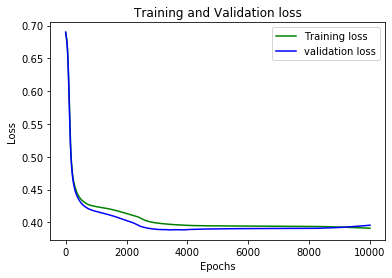

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class Processor():
    
    def __init__(self):
        self.nn_architecture = [{"input_dim" : 2, "output_dim" : 20}, {"input_dim" : 20, "output_dim" : 10}, 
                               {"input_dim": 10, "output_dim":1}]
        self.param_values = self.init_layers()
        self.memory = {}
        self.grad = {}
        self.train_cost_history = []
        self.val_cost_history = []
        self.learning_rate = 0.1
        self.epoch = 10000
        
    def init_layers(self):
        seed = 99
        np.random.seed(seed)
        params_values = {}

        for idx, layer in enumerate(self.nn_architecture):
            layer_idx = idx + 1
            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            # weights cannot be initialized with the same number because it leads to breaking symmetry problem.
            params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1
        return params_values
        
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def sigmoid_backward(self, dA, Z):
        sig = sigmoid(Z)
        return dA * sig * (1-sig) # (dL / dA)  * (dA / dZ)
    
    def relu_backward(self, dA):
        dZ = np.array(dA, copy = True)
        dZ[dA>=0] = 1
        dZ[dA<0] = 0
        return dZ # (dL / dA) * (dA / dZ) means : dA에서 0보다 작은 element는 0으로 놓는다. 나머지 element는 그대로        

    def forward(self, x):
        
        self.memory['Z1'] = np.dot(self.param_values['W1'], x) + self.param_values['b1']
        self.memory['A1'] = self.relu(self.memory['Z1'])
        self.memory['Z2'] = np.dot(self.param_values['W2'],self.memory['A1']) + self.param_values['b2']
        self.memory['A2'] = self.relu(self.memory['Z2'])
        self.memory['Z3'] = np.dot(self.param_values['W3'], self.memory['A2']) + self.param_values['b3']
        self.memory['A3'] = self.sigmoid(self.memory['Z3'])
        if(self.memory['A3'].shape[0] != 1):
            print("output dimension exception")
            
    def cost_function(self, y_hat, y):
        m = y_hat.shape[1] # example size
        self.cost = (-1 / m) * (np.dot(y, np.log(y_hat).T) + np.dot(1-y, np.log(1-y_hat).T))
        self.cost = np.squeeze(self.cost) # remove the single tone of array
        return self.cost
        
    def back_propagation(self, x, y):
        
        m = y.shape[0]
        y = y.reshape(self.memory['A3'].shape)
        self.grad["dZ3"] = self.memory['A3']-y
        self.grad["dW3"] = (1/m) * np.dot(self.grad['dZ3'], self.memory['A2'].T)
        self.grad["db3"] = (1/m) * np.sum(self.grad['dZ3'], axis=1, keepdims = True)
        self.grad["dZ2"] = np.multiply(np.dot(self.param_values['W3'].T, self.grad['dZ3']), self.relu_backward(self.memory['Z2']))
        self.grad["dW2"] = (1/m) * np.dot(self.grad['dZ2'], self.memory['A1'].T)
        self.grad["db2"] = (1/m) * np.sum(self.grad['dZ2'], axis=1, keepdims = True)
        self.grad["dZ1"] = np.multiply(np.dot(self.param_values['W2'].T, self.grad['dZ2']), self.relu_backward(self.memory['Z1']))
        self.grad["dW1"] = (1/m) * np.dot(self.grad['dZ1'], x.T)
        self.grad["db1"] = (1/m) * np.sum(self.grad['dZ1'], axis=1, keepdims = True)

        return self.cost_function(self.memory['A3'], y)
        
    def param_update(self):
        for idx, layer in enumerate(self.nn_architecture):
            idx = idx+1
            self.param_values["W"+str(idx)] -= self.learning_rate * self.grad["dW"+str(idx)]
            #print("after : ", self.param_values['W1'])
            self.param_values["b"+str(idx)] -= self.learning_rate * self.grad["db"+str(idx)]

    def model_accuracy(self, x, y):
        self.forward(x)
        y_label = self.memory['A3']
        y_label = np.squeeze(y_label)
        y_label[y_label>=0.5] = 1
        y_label[y_label<0.5] = 0
        print("model_accuracy is : ", sum(y_label == y)/len(y))

    def train(self, x_train, y_train, x_val, y_val):
        for epoch in range(self.epoch):
            self.forward(x_train)
            cost = self.back_propagation(x_train, y_train)
            self.param_update()
            self.train_cost_history.append(cost)
            self.forward(x_val)
            cost = self.cost_function(self.memory['A3'], y_val)
            self.val_cost_history.append(cost)

            if(epoch % 1000 == 0):
                print("cost at epoch", epoch, " : ", cost)

                
    def visualize(self):
        epochs = range(0, self.epoch)
        plt.plot(epochs, self.train_cost_history, 'g', label = 'Training loss')
        plt.plot(epochs, self.val_cost_history, 'b', label = 'validation loss')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show
                

def main():
    train_data = np.loadtxt("./two_moon_0.5/train.txt")
    val_data = np.loadtxt("./two_moon_0.5/val.txt")
    test_data = data = np.loadtxt("./two_moon_0.5/test.txt")

    x_train = np.transpose(train_data[0:,0:2])
    y_train = np.transpose(train_data[0:,2])
    x_val = np.transpose(val_data[0:, 0:2])
    y_val = np.transpose(val_data[0:, 2])
    x_test = np.transpose(test_data[0:,0:2])
    y_test = np.transpose(test_data[0:,2])

    processor = Processor()
    processor.train(x_train, y_train, x_val, y_val)
    processor.visualize()
    processor.model_accuracy(x_test, y_test)

    #print(processor.param_values)
    #print(processor.param_values['W1'].shape)
    #print(processor.param_values['W2'].shape)
    #print(processor.param_values['b1'].shape)
    #print(processor.param_values['b2'].shape)
        
if __name__ == '__main__':
    main()
    
    
